In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
import seaborn as sns

In [5]:
file_path = r"C:\Users\Admin\RIYA PROJECT\DATASETS\noaa_sst.nc"

## Data extraction

In [73]:
# Define target latitude, longitude, and time range
lat_min, lat_max = 16, 21 
lon_min, lon_max = 69, 75
start_year = 2019
end_year = 2024  # 5-year period

In [6]:
ds = xr.open_dataset(file_path, engine="netcdf4")
print(ds)

<xarray.Dataset>
Dimensions:  (time: 72, lat: 20, lon: 24)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2024-12-01
  * lat      (lat) float32 16.12 16.38 16.62 16.88 ... 20.12 20.38 20.62 20.88
  * lon      (lon) float32 69.12 69.38 69.62 69.88 ... 74.12 74.38 74.62 74.88
Data variables:
    sst      (time, lat, lon) float32 ...


In [7]:
a=ds['sst'].count()
a

<xarray.DataArray 'sst' ()>
array(23184)

In [75]:
sst_var = "sst" 

In [76]:
sst_data = ds[sst_var].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)) 

In [77]:
print(sst_data)

<xarray.DataArray 'sst' (time: 73, lat: 20, lon: 20)>
array([[[26.843548, 26.89    , ...,       nan,       nan],
        [26.777418, 26.906128, ...,       nan,       nan],
        ...,
        [25.983547, 25.911934, ...,       nan,       nan],
        [25.83387 , 25.653547, ...,       nan,       nan]],

       [[26.981785, 27.294641, ...,       nan,       nan],
        [27.023214, 27.314999, ...,       nan,       nan],
        ...,
        [25.242857, 25.221071, ...,       nan,       nan],
        [25.154642, 25.03857 , ...,       nan,       nan]],

       ...,

       [[27.64129 , 27.751934, ...,       nan,       nan],
        [27.710644, 27.824192, ...,       nan,       nan],
        ...,
        [25.963871, 25.829355, ...,       nan,       nan],
        [25.851934, 25.66742 , ...,       nan,       nan]],

       [[27.476774, 27.59129 , ...,       nan,       nan],
        [27.220322, 27.399355, ...,       nan,       nan],
        ...,
        [25.857418, 25.709677, ...,       nan,   

In [78]:
# Filter data for the desired time range
sst_data = sst_data.sel(time=slice(f"{start_year}-01", f"{end_year}-01"))

In [84]:
# Convert to Pandas DataFrame for easier manipulation
sst_df = sst_data.to_dataframe().reset_index()

## Data cleaning

In [25]:
# Replace flagged missing values with NaN 
sst_df[sst_var] = sst_df[sst_var].replace(-9.96921e+36, np.nan) 

# Drop rows with NaN values
sst_df.dropna(inplace=True)

# Basic statistics check
print(sst_df.describe())

                lat           lon           sst
count  19642.000000  19642.000000  19642.000000
mean      18.409161     71.039596     28.429396
std        1.441707      1.187636      1.430243
min       16.125000     69.125000     21.711428
25%       17.125000     70.125000     27.719500
50%       18.375000     71.125000     28.596202
75%       19.625000     72.125000     29.404436
max       20.875000     73.375000     31.490000


In [26]:
#Remove unrealistic SST values (valid SST range: -2°C to 35°C)
sst_df = sst_df[(sst_df[sst_var] >= -2) & (sst_df[sst_var] <= 35)]

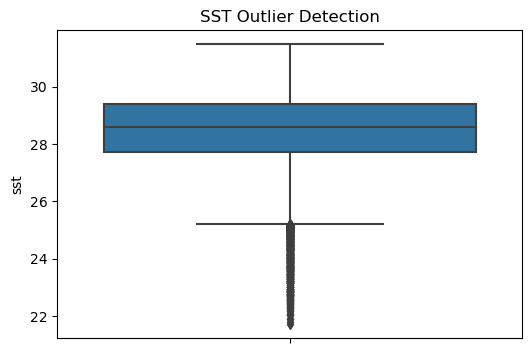

In [27]:
# Check for outliers using boxplot
plt.figure(figsize=(6, 4)) 
sns.boxplot(y=sst_df[sst_var])
plt.title("SST Outlier Detection") 
plt.show()

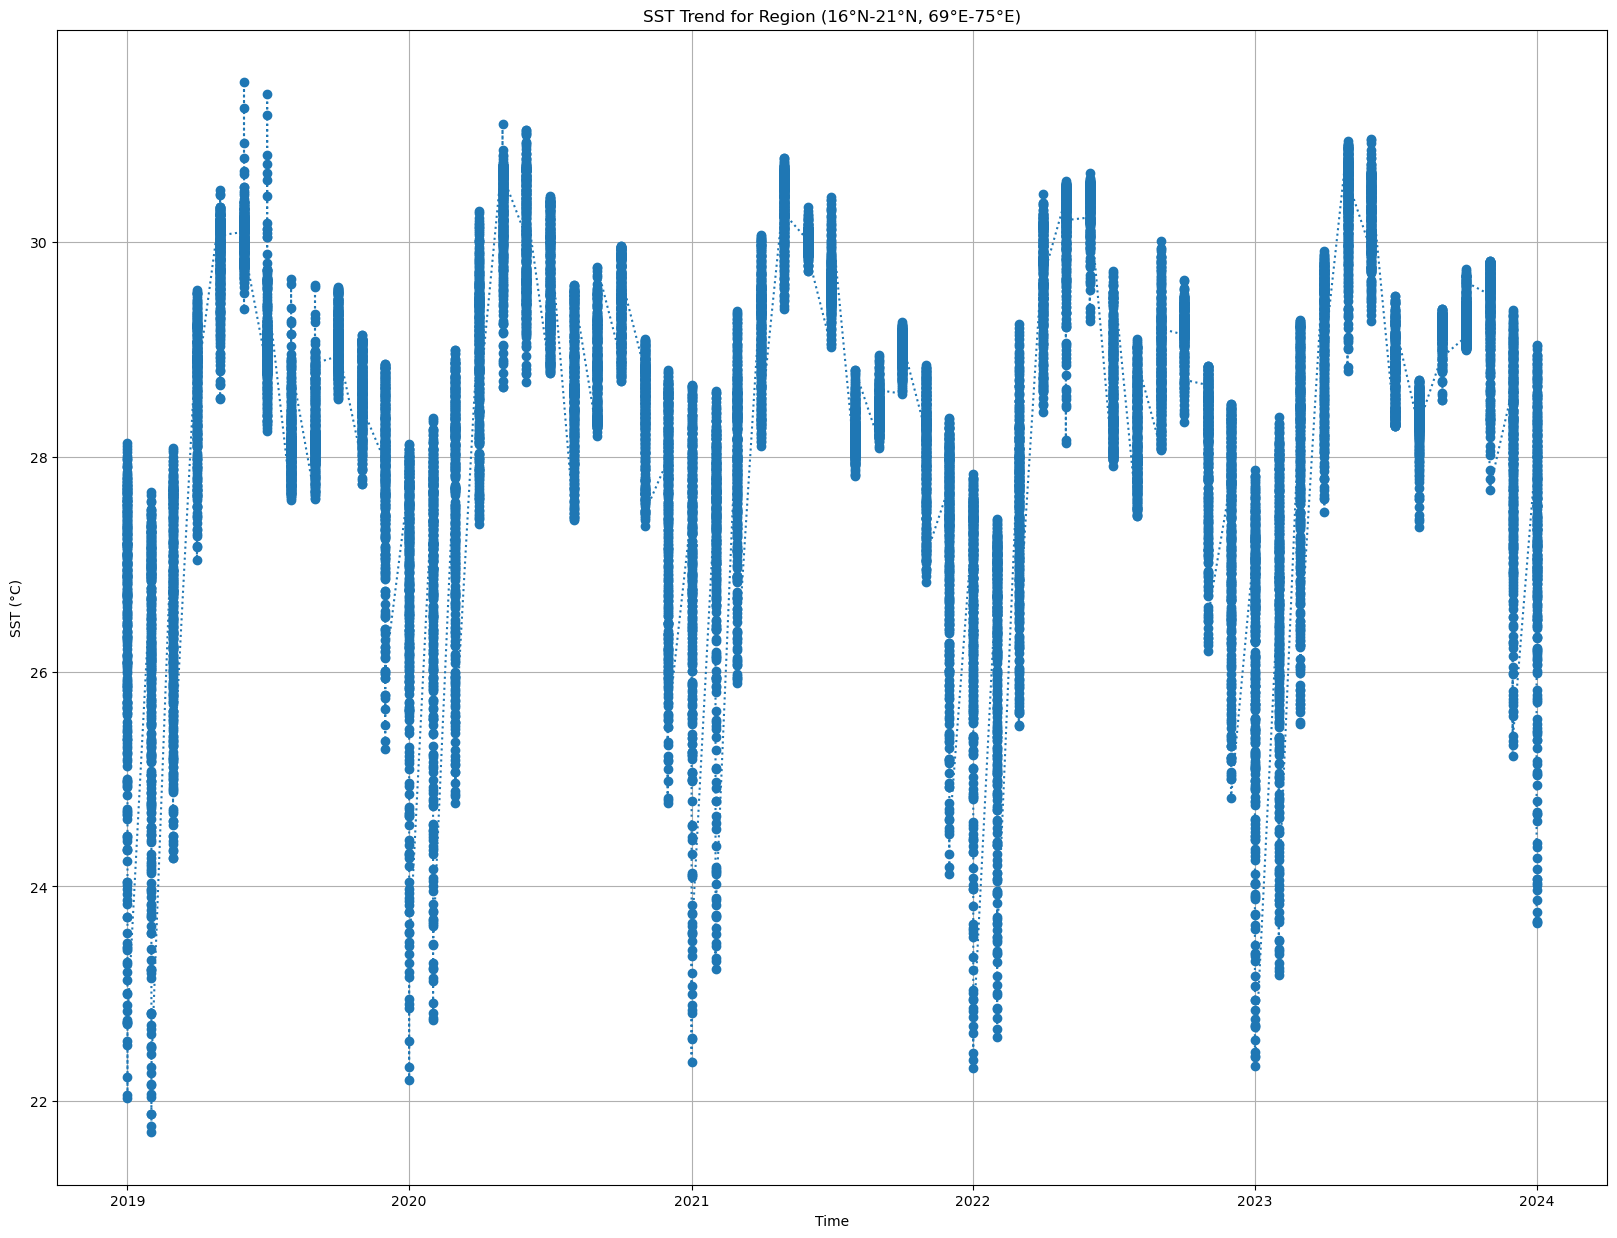

In [28]:
# Plot SST trend over time
plt.figure(figsize=(20,15))
plt.plot(sst_df["time"], sst_df[sst_var], marker="o", linestyle=":")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.title(f"SST Trend for Region ({lat_min}°N-{lat_max}°N, {lon_min}°E-{lon_max}°E)")
plt.grid()
plt.show()


In [51]:
#Save cleaned data to CSV 
sst_cleaned= sst_df.to_csv("sst_cleaned.csv", index=False) 

In [52]:
print(sst_df.shape)

(19642, 4)


In [53]:
df=pd.read_csv("sst_cleaned.csv")

In [54]:
df

,time,lat,lon,sst
0,2019-01-01,16.125,69.125,26.843548
1,2019-01-01,16.125,69.375,26.890000
2,2019-01-01,16.125,69.625,27.021290
3,2019-01-01,16.125,69.875,27.246773
4,2019-01-01,16.125,70.125,27.497742
...,...,...,...,...
19637,2024-01-01,20.875,71.875,23.661936
19638,2024-01-01,20.875,72.125,23.876130
19639,2024-01-01,20.875,72.375,24.158386
19640,2024-01-01,20.875,72.625,24.017096


In [55]:
# Check the shape of the data and decide on the appropriate dimensions
num_elements = df.shape[0]
time_dim = 73  # For example
lat_dim = 20   # For example
lon_dim = num_elements // (time_dim * lat_dim)  # Adjust based on your data structure

# If lon_dim is not an integer, you might need to reconsider the dimensions or adjust the dataset
if num_elements % (time_dim * lat_dim) != 0:
    raise ValueError("Dimensions do not match the total number of elements in the dataset")

# Reshape the data (ensure data aligns with time, latitude, longitude dimensions)
sst_values = df['sst'].values.reshape(time_dim, lat_dim, lon_dim)

# Convert the reshaped data to an xarray Dataset
dfs = xr.Dataset(
    {
        'sst': (['time', 'lat', 'lon'], sst_values)
    },
    coords={
        'time': df['time'].unique(),
        'lat': df['latitude'].unique(),
        'lon': df['longitude'].unique()
    }
)


# Save the xarray Dataset to a NetCDF file
dfs.to_netcdf('sst.nc')

ValueError: Dimensions do not match the total number of elements in the dataset

In [56]:
print(sst_df)

            time     lat     lon        sst
0     2019-01-01  16.125  69.125  26.843548
1     2019-01-01  16.125  69.375  26.889999
2     2019-01-01  16.125  69.625  27.021290
3     2019-01-01  16.125  69.875  27.246773
4     2019-01-01  16.125  70.125  27.497742
...          ...     ...     ...        ...
24391 2024-01-01  20.875  71.875  23.661936
24392 2024-01-01  20.875  72.125  23.876129
24393 2024-01-01  20.875  72.375  24.158386
24394 2024-01-01  20.875  72.625  24.017096
24395 2024-01-01  20.875  72.875  23.759354

[19642 rows x 4 columns]


In [38]:
# Check for duplicate rows
print(sst_df.duplicated().sum())

0


In [50]:
print(sst_df['lat'].unique()) 
print(sst_df['lon'].unique())
print(sst_df['sst'].unique())

[16.125 16.375 16.625 16.875 17.125 17.375 17.625 17.875 18.125 18.375
 18.625 18.875 19.125 19.375 19.625 19.875 20.125 20.375 20.625 20.875]
[69.125 69.375 69.625 69.875 70.125 70.375 70.625 70.875 71.125 71.375
 71.625 71.875 72.125 72.375 72.625 72.875 73.125 73.375]
[26.843548 26.89     27.02129  ... 24.158386 24.017096 23.759354]


#  Detect Anomalies

## ~ Anomaly Detection (Z-Score Method)

In [19]:
# How Z-Score Works?
#  Z-score = (Value - Mean) / Standard Deviation
# If |Z-score| > 2 or 3, the value is an outlier.


In [20]:
# NOT DOING SINCE Z SCORE IS AN EXTREME METHOD AND IT REMOVED TOO MUCH DATA 
"""from scipy.stats import zscore 

# Compute Z-scores for SST 
sst_df["z_score"] = zscore(sst_df[sst_var]) 

# Remove outliers beyond |Z| > 3 (Highly unusual values) 
sst_df = sst_df[np.abs(sst_df["z_score"]) > 3] 

# Drop Z-score column 
sst_df.drop(columns=["z_score"], inplace=True)
print("Outliers removed using Z-score method.")"""

'from scipy.stats import zscore \n\n# Compute Z-scores for SST \nsst_df["z_score"] = zscore(sst_df[sst_var]) \n\n# Remove outliers beyond |Z| > 3 (Highly unusual values) \nsst_df = sst_df[np.abs(sst_df["z_score"]) > 3] \n\n# Drop Z-score column \nsst_df.drop(columns=["z_score"], inplace=True)\nprint("Outliers removed using Z-score method.")'

In [21]:
"""# Check for outliers using boxplot
plt.figure(figsize=(6, 4)) 
sns.boxplot(y=sst_df[sst_var])
plt.title("SST Outlier Detection") 
plt.show()"""

'# Check for outliers using boxplot\nplt.figure(figsize=(6, 4)) \nsns.boxplot(y=sst_df[sst_var])\nplt.title("SST Outlier Detection") \nplt.show()'

##  Moving Average Smoothing (Optional)

In [22]:
# If your SST data is noisy, apply moving average smoothing to get a clearer trend :
#    Helps remove short-term fluctuations and highlight long-term SST trends.
#    Prevents misleading spikes in data.

# apply 3-Month Moving Average

# NOT NECESSARY SINCE OUR DATA IS ALREADY PROPER AS SHOWN IN BELOW FIG

In [23]:
# Apply a rolling average (window size = 3 months) 
"""sst_df["sst_smoothed"] = sst_df[sst_var].rolling(window=3, min_periods=1).mean()  #adds a column of smoothed values
# Plot smoothed SST trend
plt.figure(figsize=(10, 5)) 
plt.plot(sst_df["time"], sst_df["sst_smoothed"], marker="o", linestyle="-", label="Smoothed SST") 
plt.plot(sst_df["time"], sst_df[sst_var], alpha=0.5, label="Original SST") 
plt.xlabel("Time") 
plt.ylabel("SST (°C)") 
plt.title("SST Trend (Smoothed vs. Original)") 
plt.legend()
plt.grid() 
plt.show()"""

'sst_df["sst_smoothed"] = sst_df[sst_var].rolling(window=3, min_periods=1).mean()  #adds a column of smoothed values\n# Plot smoothed SST trend\nplt.figure(figsize=(10, 5)) \nplt.plot(sst_df["time"], sst_df["sst_smoothed"], marker="o", linestyle="-", label="Smoothed SST") \nplt.plot(sst_df["time"], sst_df[sst_var], alpha=0.5, label="Original SST") \nplt.xlabel("Time") \nplt.ylabel("SST (°C)") \nplt.title("SST Trend (Smoothed vs. Original)") \nplt.legend()\nplt.grid() \nplt.show()'